In [1]:
from PIL import Image
import numpy as np
import ipywidgets as widgets
import io

In [2]:
upload = widgets.FileUpload(
    accept='.png',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)
upload

FileUpload(value={}, accept='.png', description='Upload')

In [4]:
for name, file_info in upload.value.items():
    image_raw = Image.open(io.BytesIO(file_info['content']))

In [6]:
dropdown = widgets.Dropdown(options = [("Sobel",[-1, 0, 1, -2, 0, 2, -1, 0, 1, 1]),("Sharpen",[0, -1, 0, -1, 5, -1, 0, -1, 0, 1])],description = "Filter: ")
dropdown

Dropdown(description='Filter: ', options=(('Sobel', [-1, 0, 1, -2, 0, 2, -1, 0, 1, 1]), ('Sharpen', [0, -1, 0,…

In [7]:
IMG_SIZE = (1920,1080)

# Resize and force to RGB colours
image = image_raw.resize(IMG_SIZE).convert('RGB')

# Interpret as a 3D array of bytes (uint8)
image_array = np.array(image, dtype=np.uint8)

# Add extra padding on the X and Y dimensions
image_array_padded = np.pad(image_array, ((1,1),(1,1),(0,0)), 'symmetric')

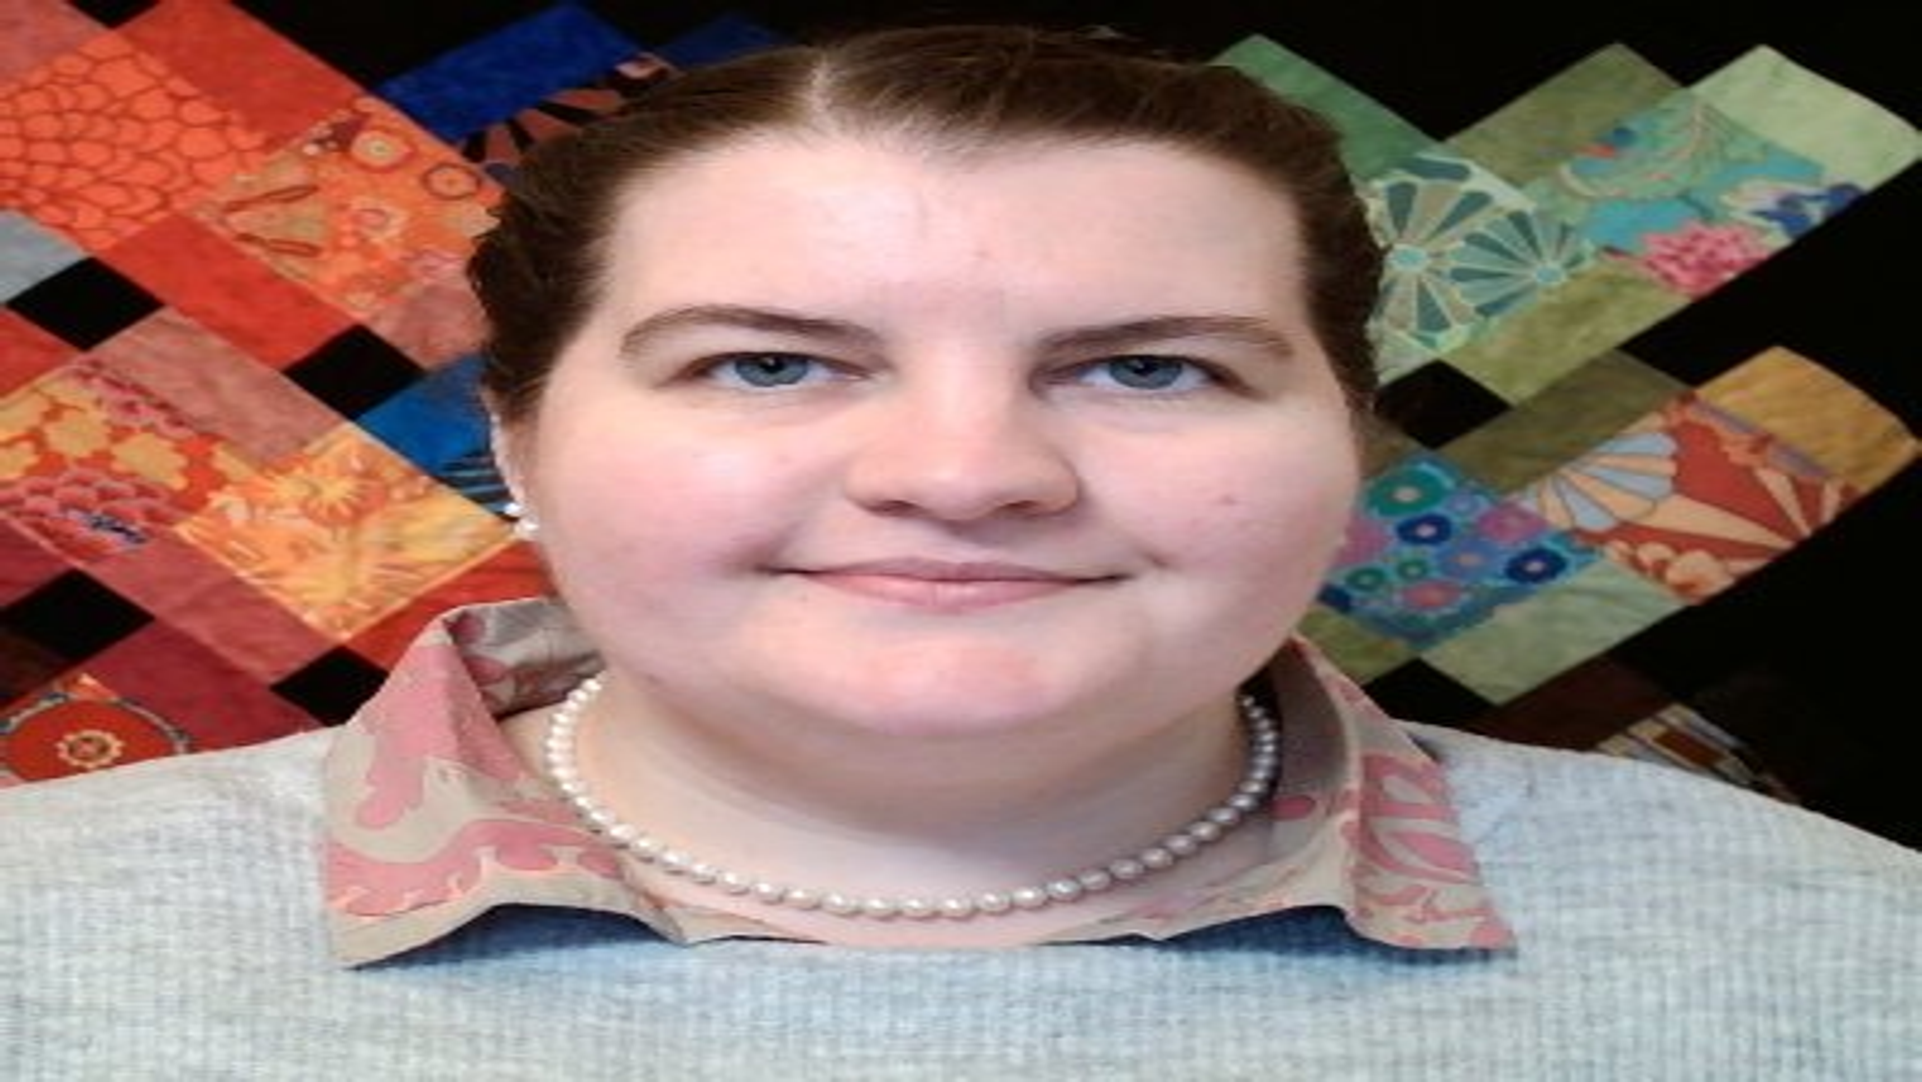

In [8]:
Image.fromarray(image_array_padded, 'RGB')

In [9]:
from pynq import Overlay
from pynq import allocate
#import pynq_sobel
import os
Kernel_Overlay = Overlay("general_filter_wrapper.bit")

In [10]:
Kernel_Overlay?

In [11]:
#Input array for DMA use
kernel_in_dma_array  = allocate(shape=(IMG_SIZE[1]+2, IMG_SIZE[0]+2, 4), dtype=np.uint8)

# Output array for DMA use
kernel_out_dma_array = allocate(shape=(IMG_SIZE[1],IMG_SIZE[0]), dtype=np.uint32)

In [12]:
def do_conv(image_array,Kernel = [0.1, 0, 0, 0, 1, 0, 0, 0, 1], div = 1):
    # Set overlay threshold
    
    Kernel_Overlay.general_filter_0.write(0x20, Kernel[0]) #W00 
    Kernel_Overlay.general_filter_0.write(0x1C, Kernel[1]) #W01 
    Kernel_Overlay.general_filter_0.write(0x18, Kernel[2]) #W02
    Kernel_Overlay.general_filter_0.write(0x14, Kernel[3]) #W10
    Kernel_Overlay.general_filter_0.write(0x10, Kernel[4]) #W11
    Kernel_Overlay.general_filter_0.write(0x0C, Kernel[5]) #W12
    Kernel_Overlay.general_filter_0.write(0x08, Kernel[6]) #W20
    Kernel_Overlay.general_filter_0.write(0x04, Kernel[7]) #W21
    Kernel_Overlay.general_filter_0.write(0x00, Kernel[8]) #W22
    Kernel_Overlay.general_filter_0.write(0x24,       div) #Matrix division
    # Copy image array into dma buffer
    kernel_in_dma_array[:, :, :3] = image_array[:, :, :]
    
    Kernel_Overlay.axi_dma.recvchannel.transfer(kernel_out_dma_array)
    Kernel_Overlay.axi_dma.sendchannel.transfer(kernel_in_dma_array)

    Kernel_Overlay.axi_dma.sendchannel.wait()
    Kernel_Overlay.axi_dma.recvchannel.wait()
    
    return kernel_out_dma_array

In [31]:
Kernel = dropdown.value[0:9]
div = dropdown.value[9]

In [32]:
%time image_output = do_conv(image_array_padded,Kernel,div)

CPU times: user 389 ms, sys: 0 ns, total: 389 ms
Wall time: 478 ms


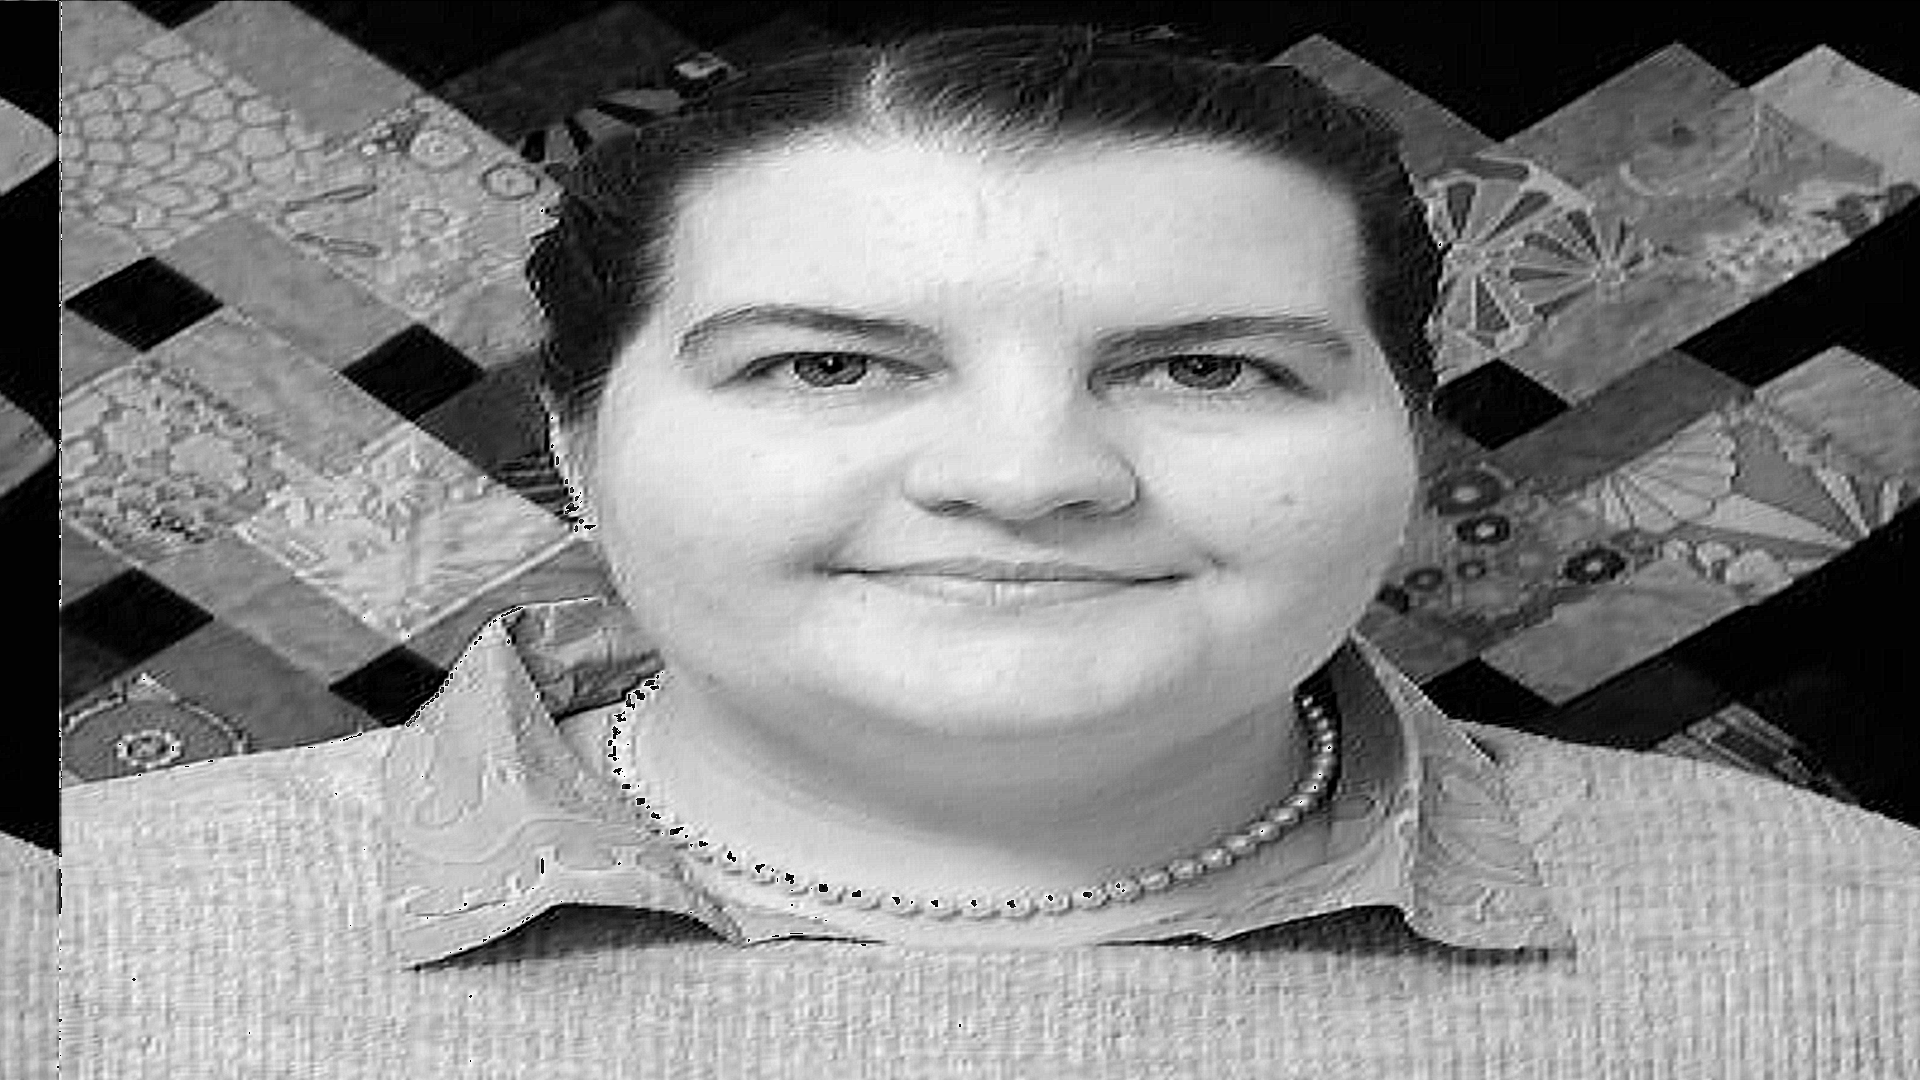

In [33]:
Image.fromarray(np.uint8(image_output), mode='P')